# Class 4 - Bias-variance trade-off and Decision Trees
Yesterday, we introduce the notions of bias and variance, which quantify two dimensions of error in predictive modeling. We saw that:
- *Bias* is the distance between the average of predictions made by a given model when trained on different training sets and the predictions made by the true model;
- *Variance* is the variance of predictions made by a given model when trained on different training sets.

Importantly, bias and variance are modulated by the complexity or flexibility of a model in different ways. As complexity/flexibility increases, bias tends to decrease, while variance increases.

This is why we talk about a _bias-variance trade-off_: ideally, we want to minimize both sources of prediction error, but in practice, modeling decisions that lead to lower bias will also lead to higher variance (and viceversa).
What we want to do when designing our model is to hit the optimal balance between bias and variance.

Alongside this, we introduced **decision trees** as an additional modeling algorithm for both regression and classification.
Decision trees are implemented in `scikit-learn`. You can check out this link for a brush-up of what they are with some examples: https://scikit-learn.org/stable/modules/tree.html. 
Classes for regression (`DecisionTreeRegressor`) and classification (`DecisionTreeClassifier`) are documented respectively at: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html and https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html. 
We have discussed hyperparameters of decision trees that influence its complexity and flexibility (e.g., tree depth, minimum number of total samples per leaf), and discussed why flexibility matters for learning good decision trees.

In this exercise, we will take a break from our attempt to model bike data (fear not, we will resume next week and combine all we have learned so far with tree-based bagging and boosting methods, which we will introduce next week).
Our goal for today is see some of the notions we have introduced theoretically during our lecture in action, to get a better grasp of these complex notions.
We will look at a practical example of how bias and variance are modulated by model flexibility, using a linear model and decision trees as a test case.

### Today's plan
**Step 1** - Generating Data:
1. Generate 1000 data points from a uniform distribution, using `numpy.random.uniform` (https://numpy.org/doc/stable/reference/random/generated/numpy.random.uniform.html). Set the minimum value to -10 and the maximum value to 10. This will be your $x$.
2. Generate polynomial terms for x, using `sklearn.preprocessing.PolynomialFeatures` (https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html)
3. Generate 4 random coefficients $\beta_{i}$ from a uniform distribution (same parameters as above)
4. Generate an outcome variable using the following equation: $y = \beta_{0} + \beta_{1} * x + \beta_{2} * x^2 + \beta_{3} * x^3 $. To do so, you might find 
5. Add some Gaussian noise to your $y$ using `np.random.normal` (set the `scale` parameter to 10 to make this noise "visible", see https://numpy.org/doc/stable/reference/random/generated/numpy.random.normal.html)
6. Plot the relation between $x$ and $y$
7. Finally, split your data into two halves, a training and a test set, using sklearn's `train_test_split`

**Step 2** - Compute squared bias and variance of linear models with increasing complexity:
1. Compute average **squared bias**, **variance**, and **MSE** for a linear model that only uses *x* as input feature.
    - To do so, you need to create a loop where you take random samples of the training data (1/2 the size of the training set), say, 100 times. This process is called **bootstrapping**.
    - For each random split of the data:
        - You fit a `LinearRegression` estimator on the sampled data
        - You predict $\hat{y}$ for all test data points
        - You compute the average **squared** bias across all data points in the test set. To do so you need to:
            1. Compute the average prediction of your bootstrapped models for each data point
            2. Compute the difference between these values and the predictions of the true model for each data point
            3. Take the squared value of that
            4. Average across all data points
            5. NOTE: we look at the average *squared* bias, because the bias of a single data point encodes information about the *directionality* of the error. If we averaged those values, we will underestimate models' tendency to make systematic errors.
        - You compute the average variance of the predictions of bootstrapped models across all data points in the test set
        - You compute the average MSE of your method (computing the average of MSEs of each bootstrapped model)
2. Now that you know how to compute this, scale this up. Fit linear regressions with input features that include increasingly high polynomial expansions of your feature set (first only $x, x^2$, then $x, x^2, x^3$ and all the way up to $x,...,x^{10}$)
3. Make a plot where you show how bias, variance and MSE change as a function of model complexity (i.e., how many polynomials you include)
4. Look at the patterns emerging from the plot and discuss them with your group: what do you notice?

**Bonus tasks**:
- We have talked about decision trees in the lecture. Can you do minimal changes to the code above, to look at how bias and variance change as a function of the expected depth of a tree, or additional parameters related to the complexity of a decision tree? Use `DecisionTreeRegressor` (https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html) as an extractor, and loop over multiple values of `max_depth` (e.g., ranging from 1 to 20)
- How do your results change as you manipulate parameters such as the the true generative model (e.g., its complexity), the size of bootstrapped data samples, etc?


### Solutions
As usual, you will find a solution in `example.ipynb`

In [1]:

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree as tr
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as pltv

### 1. Generating data 
we work with generated data (X, y) so that we know the true data (and how there is variance and bias)

In [2]:
# create vector of 1000 x_1 values (values between -10 and 10 from uniform dist)
x = np.random.uniform(low=-10, high=10, size=(1000,1)) # this is an array with a single feature

##### 1.2. Generating polynomial extensions for x

In [3]:
# expand it into matrix of x2, x1^2 and x2^3 --- so these are polynomial extensions of x
degree = 3 # this variable specifies up to which degree we want to compute polynomial expansions
X = PolynomialFeatures(degree=degree).fit_transform(x) # here, we compute x^2 and x^3
print(X.shape)
X # here they are shown as a row where the first is x0 (the constant 1) and then x^1, x^2 etc. 

(1000, 4)


array([[ 1.00000000e+00, -2.83067244e-01,  8.01270646e-02,
        -2.26813474e-02],
       [ 1.00000000e+00, -8.87745314e+00,  7.88091742e+01,
        -6.99624750e+02],
       [ 1.00000000e+00, -1.17110384e+00,  1.37148420e+00,
        -1.60615042e+00],
       ...,
       [ 1.00000000e+00,  5.55747395e-03,  3.08855167e-05,
         1.71645455e-07],
       [ 1.00000000e+00,  7.90144718e+00,  6.24328675e+01,
         4.93310005e+02],
       [ 1.00000000e+00,  4.16155209e-01,  1.73185158e-01,
         7.20719058e-02]])

##### 1.3. Generating $\beta$ values for our polynomial model
Let's generate y based on a linear equation. To do so, we generate some random coefficients $\beta_{i}$, and we compute linear combinations of these coefficients and respective polynomials

In [4]:
# creating four beta values 
coefs = np.random.uniform(low=-10, high=10, size=(degree+1,))
print(coefs)

[-7.77922747 -9.74111578 -9.34682124 -9.43741311]


##### 1.3 and 1.4 Generating outcome $y$ with noise
$y = \beta_{0} + \beta_{1} \cdot x + \beta_{2} \cdot x^2 + \beta_{3} \cdot x^3 $ 

In [5]:
# creating y's based on betas by multiplying with the coefficient and adding noise (np.random.normal)
noise = np.random.normal(0, 100, size=X.shape)
y = np.sum(X * coefs + noise, axis=1)
y.shape

(1000,)

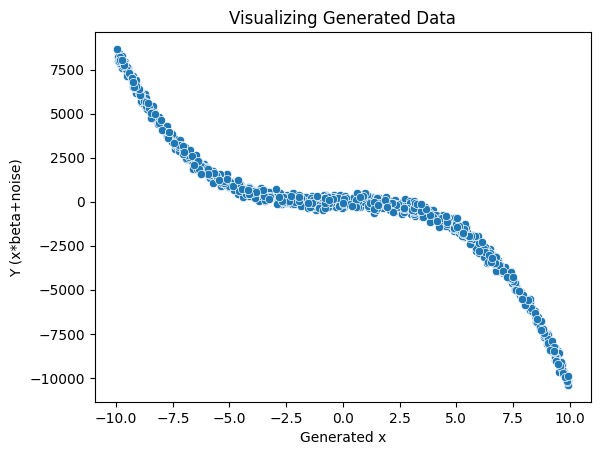

In [6]:
from matplotlib import pyplot as plt

sns.scatterplot(x=x[:,0],y=y) ### x is the true values, y is the generated outcome based on x + noise + beta coefs 
plt.title("Visualizing Generated Data")
plt.xlabel("Generated x")
plt.ylabel("Y (x*beta+noise)")
plt.show()

# Step 2.
Now lets build loops sampling from training data fitting a lin reg to each of the subset we are looping over

Bias: work with squared distances when averaging, to avoid that we just average to 0 

(true - avg_pred)^2

In [55]:
##### lets split the data: 
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=.5)
y_pred_true = np.sum(X_test*coefs, axis=1) ### here we find the true y values given our poly model with the generated betas 


##### Defining bias and variance

In [42]:
def _compute_bias(pred, true):
    '''this calculates the bias of a model based on the predicted and true model_selection.
    The distance between the true values (given the true model and betas) and the predicted.

    The average of the difference between the true and predicted ^2 
    '''
    mpred = pred.mean() # taking the mean on the rows (1st axis)
    return (((true - mpred)**2).mean())


def _compute_variance(pred):
    ''' Using the "var" function to get the variance for the rows and then taking the mean of this.
        So mean variance of all estimated ys.
    '''
    return pred.var().mean()


#### in both functions above i have removed the axis = 1, because the y's i get in the split below do not have several dimensions 
from sklearn.metrics import mean_squared_error
def _compute_MSE(y_true, y_pred):
    ''' computing the mean squared error (turns out scikit got our covered, so we just use their function).
    '''
    return mean_squared_error(y_true, y_pred)



 ##### 2.1 Average squared bias, variance and MSE
 - To do so, you need to create a loop where you take random samples of the training data (1/2 the size of the training set), say, 100 times. This process is called **bootstrapping**.
    - For each random split of the data:
        - You fit a `LinearRegression` estimator on the sampled data
        - You predict $\hat{y}$ for all test data points
        - You compute the average **squared** bias across all data points in the test set. To do so you need to:
            1. Compute the average prediction of your bootstrapped models for each data point
            2. Compute the difference between these values and the predictions of the true model for each data point
            3. Take the squared value of that
            4. Average across all data points
            5. NOTE: we look at the average *squared* bias, because the bias of a single data point encodes information about the *directionality* of the error. If we averaged those values, we will underestimate models' tendency to make systematic errors.
        - You compute the average variance of the predictions of bootstrapped models across all data points in the test set
        - You compute the average MSE of your method (computing the average of MSEs of each bootstrapped model)

In [135]:
####### lets bootstrap: 
n_bootstrap = 100
reg = LinearRegression()
df = pd.DataFrame()
pred_dat = []


for boot in range(n_bootstrap):
    ### BOOTSTRAPPING: this we do by splitting into test/train for x and y
    X_train_boot, X_test_boot, y_train_boot, y_test_boot = train_test_split(X_train,y_train,train_size=.5)

    ### fitting the model to the bootstrapped split
    model=reg.fit(X_train_boot, y_train_boot)

    #### predicting the y_boots with the reg: 
    predictions = model.predict(X_test_boot)
    #### taking the mean of all of predictions in the bootstrap:
    pred_mean = predictions.mean()
    
    ##### compute bias 
    bias = _compute_bias(pred=predictions, true=y_test_boot)
    ##### compute variance
    variance = _compute_variance(pred=predictions)

    ##### compute the average MSE: 
    MSE = _compute_MSE(y_true=y_test_boot, y_pred=predictions)
    
    #### appending results
    pred_dat.append({'bias': bias.round(4),
                     'variance': variance.round(4),
                     'MSE': MSE.round(4),
                     'mean predictoins': pred_mean.round(4)})

    

In [136]:
pred_df = pd.DataFrame(pred_dat)
pred_df['boot_nr'] = range(100)
pred_df

,bias,variance,MSE,mean predictoins,boot_nr
0,7.907062e+19,7.907062e+19,115239.6348,-3.875517e+09,0
1,5.306728e+19,5.306728e+19,123623.8353,-2.747118e+09,1
2,9.538421e+19,9.538421e+19,121792.7055,-4.401394e+09,2
3,9.866373e+19,9.866373e+19,123320.0210,-4.230888e+09,3
4,7.902384e+19,7.902384e+19,119347.2418,-3.731911e+09,4
...,...,...,...,...,...
95,8.011797e+19,8.011797e+19,121018.5015,-3.875467e+09,95
96,7.741155e+19,7.741155e+19,129445.9369,-3.949249e+09,96
97,9.981134e+19,9.981134e+19,117136.5386,-4.616228e+09,97
98,1.071474e+20,1.071474e+20,125814.8903,-4.513026e+09,98


<Axes: xlabel='variance', ylabel='bias'>

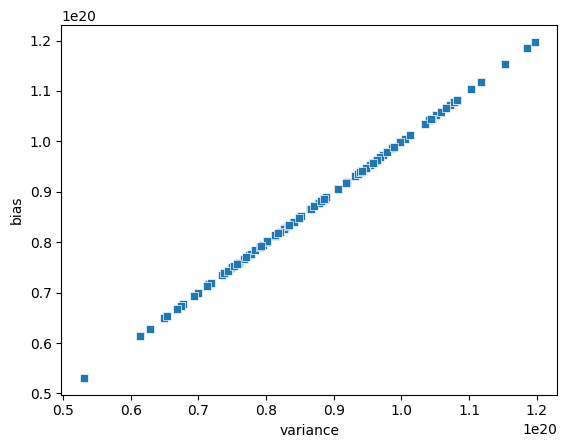

In [137]:
sns.scatterplot(data=pred_df.sort_values(by='MSE', ascending=False), 
                y='bias', 
                x='variance', 
                marker='s')

### SCALING IT UP: modeling for more expansions (up until $x^n$)

2. Now that you know how to compute this, scale this up. Fit linear regressions with input features that include increasingly high polynomial expansions of your feature set (first only $x, x^2$, then $x, x^2, x^3$ and all the way up to $x,...,x^{10}$)
3. Make a plot where you show how bias, variance and MSE change as a function of model complexity (i.e., how many polynomials you include)
4. Look at the patterns emerging from the plot and discuss them with your group: what do you notice?


*as far as I can read no bootstrapping here??*

In [142]:
### my logic here is to take it from x^1 to x^10 by looping ovee the expansions, and then for each loop making the boot strap above: 
expansions = [2,3,4,5,6,7,8,9,10] 

expppp = []

### our initial x^1:
x = np.random.uniform(low=-10, high=10, size=(1000,1))

for degree in expansions:
    ### computing all x expansions
    X = PolynomialFeatures(degree=degree).fit_transform(x)
    ### find the betas for each x:
    coefs = np.random.uniform(low=-10, high=10, size=(degree+1,))

    ### finding our true y's based on the beta: 
    noise = np.random.normal(0, 100, size=X.shape) #### adding a bit of noise to be real :p
    y = np.sum(X * coefs + noise, axis=1)

    ##### lets split the data: 
    X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=.5)
    y_pred_true = np.sum(X_test*coefs, axis=1) ### here we find the true y values given our poly model with the generated betas 

    ### fitting the model to the bootstrapped split
    model=reg.fit(X_train, y_train)

    #### predicting the y_boots with the reg: 
    predictions = model.predict(X_test)
    #### taking the mean of all of predictions in the bootstrap:
    pred_mean = predictions.mean()
    
    ##### compute bias 
    bias = _compute_bias(pred=predictions, true=y_test)
    ##### compute variance
    variance = _compute_variance(pred=predictions)

    ##### compute the average MSE: 
    MSE = _compute_MSE(y_true=y_test, y_pred=predictions)

    expppp.append({'bias': bias.round(4),
                    'complexity': degree,
                     'variance': variance.round(4),
                     'MSE': MSE.round(4),
                     'mean predictions': pred_mean.round(4)})


    
exp_df = pd.DataFrame(expppp)

#### rescaling:
for i in ['bias', 'variance', 'MSE']:
    exp_df[f'{i}-scaled'] = MinMaxScaler().fit_transform(exp_df[i].values.reshape(-1,1)) 
exp_df

,bias,complexity,variance,MSE,mean predictions,bias-scaled,variance-scaled,MSE-scaled
0,5.271624e+04,2,2.278251e+04,29541.4439,1.648375e+02,0.000000e+00,0.000000e+00,0.000000
1,2.040473e+05,3,1.460918e+05,37681.1879,6.044910e+01,4.283440e-16,3.490281e-16,0.113591
2,7.314702e+07,4,7.277278e+07,44230.6075,-6.413682e+03,2.068941e-13,2.059195e-13,0.204989
3,8.285296e+10,5,8.286129e+10,62593.3016,-2.983879e+04,2.345159e-10,2.345396e-10,0.461242
4,3.427347e+12,6,3.427473e+12,73643.8519,-1.123968e+06,9.701137e-09,9.701495e-09,0.615454
5,9.182886e+13,7,9.182857e+13,79530.9391,1.036588e+06,2.599224e-07,2.599216e-07,0.697609
6,4.304813e+16,8,4.304812e+16,96319.1788,1.102020e+08,1.218481e-04,1.218481e-04,0.931890
7,2.910849e+18,9,2.910849e+18,90832.0048,1.825887e+08,8.239186e-03,8.239186e-03,0.855316
8,3.532933e+20,10,3.532933e+20,101199.7998,-8.694489e+09,1.000000e+00,1.000000e+00,1.000000


Text(0.5, 1.0, 'lauras plot hehe comparisons of bias etc in poly models')

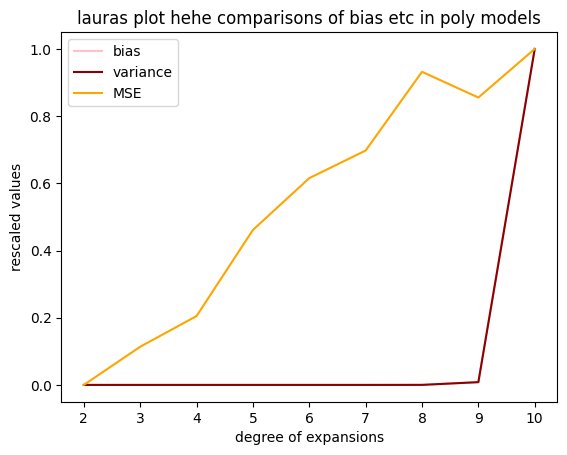

In [143]:
data = exp_df
sns.lineplot(data=data, x='complexity', y='bias-scaled', label='bias', color = 'pink')
sns.lineplot(data=data, x='complexity', y='variance-scaled', label='variance', color='darkred')
sns.lineplot(data=data, x='complexity', y='MSE-scaled', label='MSE', color='orange')
plt.xlabel('degree of expansions')
plt.ylabel('rescaled values')
plt.title('lauras plot hehe comparisons of bias etc in poly models')

In [144]:
#### the idea heres was that it should not be new coefficients/X 
# (instead we put the latter in the new as an addition to a df) 
# each time, but not sure how to do so
#SO: 
# i want to make this is a way where the already generated x expansions stays the same as more are added... 

### i do this by no longer using the poly func


# Initialize variables
expppp2 = []
reg = LinearRegression()

# Initialize coefficients with the first term's coefficient
coefs = [np.random.uniform(low=-10, high=10)]

# Start with the initial x as the only feature
X_features = x.copy()

for degree in expansions:
    # Manually compute the next degree of x and append it to the features
    new_feature = x**degree
    X_features = np.hstack([X_features, new_feature])  # Append the new feature
    
    # Generate one new coefficient for the new feature
    new_coef = np.random.uniform(low=-10, high=10)
    coefs.append(new_coef)  # Append the new coefficient

    # computing y's
    noise = np.random.normal(0, 100, size=(X_features.shape[0], ))
    y = np.dot(X_features, coefs) + noise

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X_features, y, train_size=0.5)
    
    # Fitting the model to the bootstrapped split
    model = reg.fit(X_train, y_train)
    
    # Predicting the y_boots with the reg
    predictions = model.predict(X_test)
    
    # Compute bias (as mean prediction error), variance, and MSE
    bias = np.mean(predictions - y_test)  # Simplified bias calculation
    variance = np.var(predictions)
    MSE = mean_squared_error(y_test, predictions)
    
    expppp2.append({
        'complexity': degree,
        'bias': bias,
        'variance': variance,
        'MSE': MSE,
        'mean predictions': np.mean(predictions)
    })

print(coefs)

exp_df2 = pd.DataFrame(expppp2)
exp_df2['beta_coefs'] = coefs[1:10] # not taking all cause havent stored x^1 

# Rescaling
scaler = MinMaxScaler()
for metric in ['bias', 'variance', 'MSE']:
    exp_df2[f'{metric}-scaled'] = scaler.fit_transform(exp_df2[[metric]])

exp_df2

[-8.784932642959802, 6.069291314080253, -2.0492830041632626, -9.711964259164018, -6.486896471161652, 8.946404617751845, 3.8621482409724077, 0.9685895772111959, -5.286963816247381, -4.0064077923906805]


,complexity,bias,variance,MSE,mean predictions,beta_coefs,bias-scaled,variance-scaled,MSE-scaled
0,2,-10.555368,3.356219e+04,9374.856983,2.025113e+02,6.069291,0.000000,0.000000e+00,0.035139
1,3,-8.036155,6.815871e+05,11121.799358,1.524164e+02,-2.049283,0.124313,8.055913e-15,0.826301
2,4,9.709673,6.998712e+08,9919.349536,-2.009070e+04,-9.711964,1.000000,8.700023e-12,0.281731
3,5,1.956814,3.977774e+10,10895.571114,-2.635719e+04,-6.486896,0.617427,4.944960e-10,0.723846
4,6,2.665416,4.380801e+12,9297.268325,1.352385e+06,8.946405,0.652394,5.445988e-08,0.000000
5,7,-6.883799,1.162217e+14,10139.215073,2.054755e+06,3.862148,0.181177,1.444808e-06,0.381304
6,8,6.282487,6.619631e+14,10443.864088,1.241040e+07,0.968590,0.830882,8.229187e-06,0.519275
7,9,2.901154,1.311759e+18,9880.330758,-1.433162e+08,-5.286964,0.664026,1.630712e-02,0.264060
8,10,-5.974978,8.044089e+19,11505.338665,-4.232532e+09,-4.006408,0.226024,1.000000e+00,1.000000


Text(0.5, 1.0, 'now it looks veeeery different')

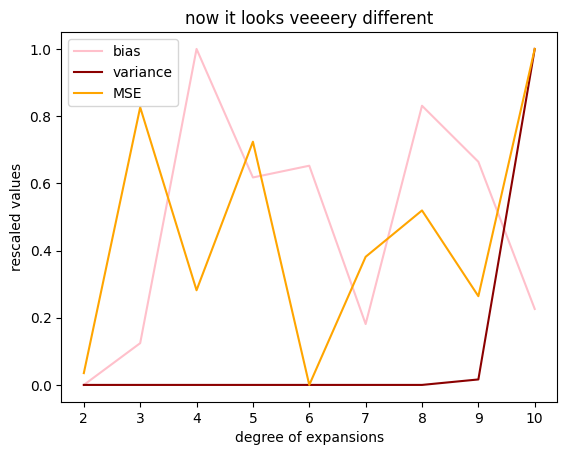

In [145]:
data = exp_df2
sns.lineplot(data=data, x='complexity', y='bias-scaled', label='bias', color = 'pink')
sns.lineplot(data=data, x='complexity', y='variance-scaled', label='variance', color='darkred')
sns.lineplot(data=data, x='complexity', y='MSE-scaled', label='MSE', color='orange')
plt.xlabel('degree of expansions')
plt.ylabel('rescaled values')
plt.title('now it looks veeeery different')

#### REMEMBER NO BOOTSTRAPPING HAS BEEN DONE YET ... 

In [147]:
### SO LETS TRY TO incorporate THAT SOMEHOW :D 
# my initial take here will be to nest the two loops - dunno how to store the data though  (I DO THIS WITH THE FIRST TYPE OF POLY X'S)

expansions = [2, 3, 4, 5, 6, 7, 8, 9, 10]
n_bootstrap = 100
reg = LinearRegression()
exp_data_ALL = []

# Initial x^1
x = np.random.uniform(low=-10, high=10, size=(1000, 1))

for degree in expansions:
    # Computing all x expansions
    X = PolynomialFeatures(degree=degree, include_bias=False).fit_transform(x)
    # Find the betas for each x
    coefs = np.random.uniform(low=-10, high=10, size=X.shape[1])
    # Finding our true y's based on the beta
    noise = np.random.normal(0, 100, size=X.shape[0])
    y = np.dot(X, coefs) + noise

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5)
    
    bootstrap_results = []
    for boot in range(n_bootstrap):
        # Bootstrapping by re-splitting training data
        X_train_boot, X_test_boot, y_train_boot, y_test_boot = train_test_split(X_train, y_train, train_size=0.5)
        
        # Fitting the model to the bootstrapped split
        model = reg.fit(X_train_boot, y_train_boot)
        
        # Predicting the y_boots with the reg
        predictions = model.predict(X_test_boot)
        
        # Computing bias, variance, and MSE
        bias = _compute_bias(predictions, y_test_boot)
        variance = _compute_variance(predictions)
        MSE = _compute_MSE(y_test_boot, predictions)
        
        bootstrap_results.append({
            'bias': bias,
            'variance': variance,
            'MSE': MSE,
            'mean_predictions': np.mean(predictions)
        })

    # Aggregating bootstrap results
    aggregated_results = {
        'bias': np.mean([result['bias'] for result in bootstrap_results]),
        'variance': np.mean([result['variance'] for result in bootstrap_results]),
        'MSE': np.mean([result['MSE'] for result in bootstrap_results]),
        'mean_predictions': np.mean([result['mean_predictions'] for result in bootstrap_results]),
        'complexity': degree
    }
    
    exp_data_ALL.append(aggregated_results)

# Creating a DataFrame from the aggregated results
exp_data_ALL_df = pd.DataFrame(exp_data_ALL)

# Rescaling
scaler = MinMaxScaler()
for metric in ['bias', 'variance', 'MSE']:
    exp_data_ALL_df[f'{metric}-scaled'] = scaler.fit_transform(exp_data_ALL_df[[metric]])

exp_data_ALL_df



,bias,variance,MSE,mean_predictions,complexity,bias-scaled,variance-scaled,MSE-scaled
0,1.264533e+04,2.855786e+03,9711.893201,5.844802e+01,2,0.000000e+00,0.000000e+00,0.530063
1,3.589036e+06,3.577358e+06,9647.523989,3.865927e+02,3,1.453331e-14,1.452564e-14,0.500848
2,2.188690e+07,2.186796e+07,9492.151839,3.569099e+03,4,8.888998e-14,8.885279e-14,0.430327
3,3.713914e+10,3.713961e+10,10505.760709,-7.444812e+03,5,1.509216e-10,1.509235e-10,0.890383
4,1.280433e+12,1.280433e+12,9634.088352,-7.358907e+05,6,5.203272e-09,5.203271e-09,0.494749
5,9.933674e+13,9.933674e+13,10747.271952,-7.573983e+05,7,4.036728e-07,4.036728e-07,1.000000
6,2.534091e+16,2.534091e+16,8544.041095,8.518811e+07,8,1.029774e-04,1.029774e-04,0.000000
7,4.124767e+18,4.124767e+18,10087.474352,-2.233441e+08,9,1.676174e-02,1.676174e-02,0.700532
8,2.460823e+20,2.460823e+20,9991.479514,7.698477e+09,10,1.000000e+00,1.000000e+00,0.656962


Text(0.5, 1.0, 'hmm only MSE seem to change')

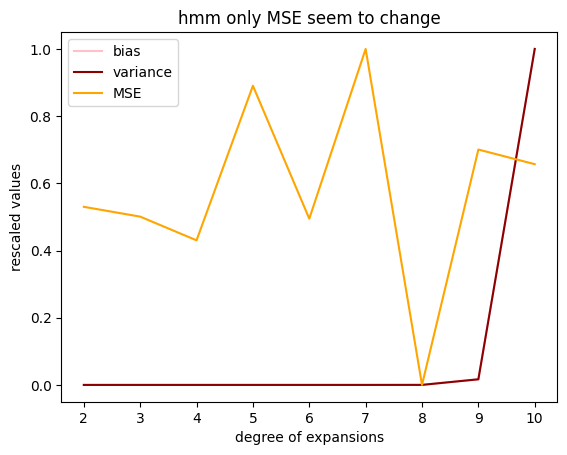

In [150]:
data = exp_data_ALL_df
sns.lineplot(data=data, x='complexity', y='bias-scaled', label='bias', color = 'pink')
sns.lineplot(data=data, x='complexity', y='variance-scaled', label='variance', color='darkred')
sns.lineplot(data=data, x='complexity', y='MSE-scaled', label='MSE', color='orange')
plt.xlabel('degree of expansions')
plt.ylabel('rescaled values')
plt.title('hmm only MSE seem to change')